---
### Load in and visualize the data

In [59]:
import numpy as np

# read data from text files
with open('data/reviews.txt', 'r') as f:
    reviews = f.read()
with open('data/labels.txt', 'r') as f:
    labels = f.read()

## 1) Preprocessing the data

### Removing Punctuations and getting all the words

In [60]:
from string import punctuation

# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])

# split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()

### Tokenize the words

In [61]:
# feel free to use this import 
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

For labels, 1=positive, 0=negative

In [62]:
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

### Fiter out the reviews, remove reviews with length 0

In [63]:
review_lens = Counter([len(x) for x in reviews_ints])
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

### Function for padding and truncation of individual reviews to form data of equal lengths

In [64]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [65]:
seq_length = 200
features = pad_features(reviews_ints, seq_length=seq_length)

## 2) Split the features and labels into training, testing and validation sets

In [66]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## 3) Create dataloaders to shuffle the datasets and set a batch size as well

In [67]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Tensor datasets
train_data = TensorDataset(torch.LongTensor(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.LongTensor(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.LongTensor(test_x), torch.from_numpy(test_y))

batch_size = 50

# Shuffle + batching
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

## 4) Training and validation
### Check if GPU is available

In [68]:
train_on_gpu=torch.cuda.is_available()

### Define the model

In [69]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        # To initialize the hidden state
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

### State the hyperparameters

In [70]:
vocab_size = len(vocab_to_int)+1 # extra +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
learning_rate=0.001

### Initialize the model

In [71]:
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Define the loss function and optimizer
Here we are using binary cross entropy loss function and Adam optimizer.

In [72]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

### Now, lets start training

In [73]:
epochs = 8
counter = 0
print_every = 10

# gradient clipping to avoid exploding gradients
clip=5 

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()

train_loss = []
validation_loss = []
last_validation_loss = np.inf

for e in range(epochs):
    
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])

        # zero the accumulated gradients
        net.zero_grad()

        # pass the data through the model
        output, h = net(inputs, h)

        # calculate the loss
        loss = criterion(output.squeeze(), labels.float())
        
        #perform backprop
        loss.backward()
        
        # gradient clipping
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        
        # one step of optimization
        optimizer.step()
        
        # validate as we train
        
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            train_loss.append(loss.item())
            validation_loss.append(np.mean(val_losses))
            
            if(validation_loss[-1] < last_validation_loss):
                print("Validation loss decreased from", last_validation_loss," to ", validation_loss[-1]," Saving model. . . .")
                last_validation_loss = validation_loss[-1]
                torch.save(net.state_dict(), 'model')

Validation loss decreased from inf  to  0.6922829735279084  Saving model. . . .
Validation loss decreased from 0.6922829735279084  to  0.6922489261627197  Saving model. . . .
Validation loss decreased from 0.6922489261627197  to  0.6877894508838653  Saving model. . . .
Validation loss decreased from 0.6877894508838653  to  0.6847143197059631  Saving model. . . .
Validation loss decreased from 0.6847143197059631  to  0.6664103746414185  Saving model. . . .
Validation loss decreased from 0.6664103746414185  to  0.6463022744655609  Saving model. . . .
Validation loss decreased from 0.6463022744655609  to  0.6383770656585693  Saving model. . . .
Validation loss decreased from 0.6383770656585693  to  0.6350162315368653  Saving model. . . .
Validation loss decreased from 0.6350162315368653  to  0.6175650769472122  Saving model. . . .
Validation loss decreased from 0.6175650769472122  to  0.6032742810249329  Saving model. . . .
Validation loss decreased from 0.6032742810249329  to  0.57744613

## Plot the losses

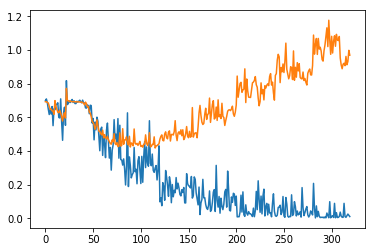

In [74]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)

## Load the model

In [81]:
net.load_state_dict(torch.load('model'))

## 5) Tesing

In [82]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicteions
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.428
Test accuracy: 0.803


In [83]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints

In [84]:
def stars(output):
    # print custom response
    if output.item()<=0.1 :
        print("0.5 stars")
    elif output.item()<=0.2 :
        print("1 star")
    elif output.item()<=0.3 :
        print("1.5 stars")
    elif output.item()<=0.4 :
        print("2 stars")
    elif output.item()<=0.5 :
        print("2.5 stars")
    elif output.item()<=0.6 :
        print("3 stars")
    elif output.item()<=0.7 :
        print("3.5 stars")
    elif output.item()<=0.18 :
        print("4 stars")
    elif output.item()<=0.9 :
        print("4.5 stars")
    elif output.item()<=1 :
        print("5 stars")
def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.LongTensor(features)
    
    batch_size = feature_tensor.size(0)
    
    # hidden state
    h = net.init_hidden(batch_size)
    
    if(torch.cuda.is_available()):
        feature_tensor = feature_tensor.cuda()
    
    output, h = net(feature_tensor, h)
    
    return output

## Test your own data
Type exit to quit

In [ ]:
x = True
while(x):
    review = input("\nEnter a review : ")
    if review == "exit":
        x = False
        break
    output = predict(net, review, 200)
    stars(output)


Enter a review : Best movie ever
5 stars

Enter a review : Worst movie ever
1 star
